Trade and patents in Python: RCAs, proximities, product space and economic complexity
=====================================================================================



September 16 2022, Matte Hartog



## Notes



Hi all,

I&rsquo;ll be going through the following notebook tomorrow

Google colab link:

[https://colab.research.google.com/github/matteha/product-space-eci-workshop/blob/main/product-space-eci-workshop-2022.ipynb](https://colab.research.google.com/github/matteha/product-space-eci-workshop/blob/main/product-space-eci-workshop-2022.ipynb)

Google colab link in R:
[https://colab.research.google.com/github/matteha/product-space-eci-workshop/blob/main/product-space-eci-workshop-in-R.ipynb](https://colab.research.google.com/github/matteha/product-space-eci-workshop/blob/main/product-space-eci-workshop-in-R.ipynb)

To run code in Google Colab, you need a Google account.

(If notebook doesn&rsquo;t run try Runtime -> Disconnect and delete runtime)



## To do first



In Google Colab:

1.  Turn on Table of Contents: (in browser, click on &rsquo;View&rsquo; in top, then &rsquo;Table of Contents&rsquo;)

2.  Expand all sections (&rsquo;View&rsquo; > &rsquo;Expand Sections&rsquo; if not greyed out)



## Outline of lab session



Google Colab gives you access to a Jupyter Notebook with a Python kernel (but other kernels are also possible, e.g. R, see

[https://github.com/IRkernel/IRkernel](https://github.com/IRkernel/IRkernel)

)

We&rsquo;ll cover:

-   Introduction to trade data

-   Calculating RCAs, co-occurences and proximities
    -   Product and technology proximities
    -   Trade: specialization of countries over time
    -   Technologies (patents): specialization of countries and US cities over time

-   Product space visualization

-   Calculating Product Complexity / Economic Complexity (by destination)



## Trade data



### Background



The product space is based on trade data between countries (as well as its derivations / related measures such as economic complexity and the Growth&rsquo;s annual rankings of countries by economic complexity (at [https://atlas.cid.harvard.edu](https://atlas.cid.harvard.edu))).

The Growth Lab maintains and periodically updates a cleaned version of trade data at Harvard Dataverse:

[https://dataverse.harvard.edu/dataverse/atlas](https://dataverse.harvard.edu/dataverse/atlas)

This dataset contains bilateral trade data among 235 countries and territories in thousands of different products categories (a description of the data can be found at: [http://atlas.cid.harvard.edu/downloads](http://atlas.cid.harvard.edu/downloads)).

How does the data look like? We will explore the data in Python using the &rsquo;pandas&rsquo; (most popular Python package for data analysis) - what &rsquo;tidyverse&rsquo; is to R.



#### Footnote on trade and services (ICT, tourism, etc.):



-   Services and tourism are included in the Growth Lab&rsquo;s Atlas and trade data as well as of September 2018. See announcement at:

[https://atlas.cid.harvard.edu/announcements/2018/services-press-release](https://atlas.cid.harvard.edu/announcements/2018/services-press-release)

Obtained from IMF, trade in services covers four categories of economic activities between producers and consumers across borders:

-   services supplied from one country to another (e.g. call centers)
-   consumption in other countries (e.g. international tourism)
-   firms with branches in other countries (e.g. bank branches overseas)
-   individuals supplying services in another country (e.g. IT consultant abroad)



### Load necessary Python libraries



In [ ]:
# -- Global settings
# - import python libraries necessary for this workshop
# suppress warnings on google colab for now
import warnings
warnings.filterwarnings("ignore")
# to interact with os, e.g. to execute shell comands such as 'ls', 'pwd' etc.
import os
# to do data processing
import pandas as pd
# backend of pandas, working with matrices
import numpy as np
# to visualize data (in pandas)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
# to process a json file
import json
# work with regex in python
import re
# work with networks in python, to create product space
import networkx as nx
# python tools to work with combinations of arrays
from itertools import count
from itertools import combinations
from itertools import product
# to download files
import urllib.request, json
# to plot data on maps
# pip install is needed on Google Colab
!pip3 install geopandas
import geopandas
# -- set scientific notation to display numbers fully rather than exponential
pd.set_option('display.float_format', '{:.2f}'.format)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # Show all results of jupyter
import seaborn as sns
sns.set_style('whitegrid') # Display grids on dark background
# to run regressions
import statsmodels.api as sm
# Enlarged pandas display - more colums and rows with greater width
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth',300)
print('necessary libraries loaded')

### Download trade dataset and load into memory



Trade data is constantly updated by the Growth Lab, you can find the most recent version of the trade data at our Dataverse here:

[https://dataverse.harvard.edu/dataverse/atlas](https://dataverse.harvard.edu/dataverse/atlas)

Below we&rsquo;re using the trade data using the HS classification (&rsquo;Harmonized System 1992&rsquo; - alternative is &rsquo;SITC - Standard Industrial Trade Classification&rsquo; which goes back further in time) at the 4 digit level (alternative is 2 or 6 - 6 has more detail). It can be found here:

[https://dataverse.harvard.edu/file.xhtml?fileId=4946953&version=4.0](https://dataverse.harvard.edu/file.xhtml?fileId=4946953&version=4.0)

The trade file we&rsquo;re using below has a fix implemented in the labels (strings) of the products - some products currently erronuously have the same strings (e.g. product codes 5209 and 5211 in Zimbabwe have the same product string). The file is regularly updated by the Growth Lab.

To load the data directly we&rsquo;re using a Dropbox link with the fix implemented (Dataverse normally requires one to fill in an agreement form first but see Section 1 (by Shreyas) on how to use the dataverse library in R to load data from there directly into R).

(The trade file is a large file because it includes country / product strings, takes 1 - 3 minutes to load. One can also merge strings in separately but for illustrative purposes it is easier to have them all preloaded - also to avoid memory problems that R quickly runs into).

Our $X_{cpt}$ matrix.



In [ ]:
# Load the necessary data into pandas
df_orig = pd.read_csv('https://www.dropbox.com/s/3n4r4qo4j0jjpln/trade.csv?dl=1')
print('trade data loaded')

### Exploring the trade data



#### Structure of dataset



Our $X_{cpt}$ matrix:



In [ ]:
df_orig.sample(n=5) # show 5 random rows

#### What years are in the data?



In [ ]:
df_orig['year'].unique()

#### How many products are in the data?



In [ ]:
df_orig['product_name'].nunique()

#### Finding specific countries / products based on partial string matching



If you&rsquo;re interested in finding data on certain countries / products but not sure how exactly these are spelled in the data (or are spelled with / without e.g. capital letters).



In [ ]:
STRING = 'Netherland'
df_orig[df_orig['country_name'].str.contains(STRING)][['country_name']].drop_duplicates()

You can also include regex expressions here, e.g. to ignore lower/uppercase (&rsquo;wine&rsquo; vs &rsquo;Wine&rsquo;)



In [ ]:
STRING = 'wine'
df_orig[df_orig['product_name'].str.contains(STRING,flags=re.IGNORECASE, regex=True)][['product_name']].drop_duplicates()

#### Example: What were the major export products of the USA in 2012?



In [ ]:
# create a 'dataframe' called 'df2' with only exports from USA in 2012
df2 = df_orig[ (df_orig['country_code']=='USA') & (df_orig['year'] == 2012) ].copy()
# create another dataframe 'df3' that contains the sum of exports per product
df3 = df2.groupby(['product_code','product_name'],as_index=False)['export_value'].sum()
# sort
df3.sort_values(by=['export_value'],ascending=False,inplace=True)
# show first 10 rows
df3[0:10]

#### Example: How did exports of Cars evolve over time in the USA?



From about 10 billion USD up to almost $60 billion USD.



In [ ]:
df2 = df_orig[ (df_orig['country_code']=='USA')].copy()
#df3 = df2[df2['product_name']=='Cars']
df3 = df2[df2['product_code']=='8703']
df3.plot(x='year', y='export_value')

## Revealed comparative advantage (RCA)



What products are countries specialized in? For that, following Hidalgo et al. (2007), we calculate the Revealed Comparative Advantage (RCA) of each country-product pair: how much a country &rsquo;over-exports&rsquo; a product in comparison to all other countries.

Technically this is the Balassa index of comparative advantage, calculated as follows for product $p$ and country $c$ at time $t$:

\begin{equation} \label{e_RCA}
{RCA}_{cpt}=\frac{X_{cpt}/X_{ct}}{X_{pt}/X_{t}}
\tag{1}
\end{equation}

where $X_{cpt}$ represents the total value of country $c$’s exports of product $p$ at time $t$ across all importers. An omitted subscript indicates a summation over the omitted dimension, e.g.: $X_{t}=\sum \limits_{c,p,t} X_{cpt}$.

A product-country pair with $RCA>1$ means that the product is over-represented in the country&rsquo;s export basket.

We use the original trade dataset (&rsquo;df<sub>orig</sub>&rsquo;) that is loaded into memory, calculating RCAs as follows:



In [ ]:
def calc_rca(data,country_col,product_col,time_col,value_col):
    """
    Calculates Revealed Comparative Advantage (RCA) of country-product-time combinations

    Returns:
        pandas dataframe with RCAs
    """

    # Aggregate to country-product-time dataframe
    print('creating all country-product-time combinations')
    # - add all possible products for each country with export value 0
    # - else matrices later on will have missing values in them, complicating calculations
    df_all = pd.DataFrame(list(product(data[time_col].unique(), data[country_col].unique(),data[product_col].unique())))
    df_all.columns=[time_col,country_col,product_col]
    print('merging data in')
    df_all = pd.merge(df_all,data[[time_col,country_col,product_col,value_col]],how='left',on=[time_col,country_col,product_col])
    df_all.loc[df_all[value_col].isnull(),value_col] = 0

    # Calculate the properties
    print('calculating properties')
    df_all['Xcpt'] = df_all[value_col]
    df_all['Xct'] = df_all.groupby([country_col, time_col])[value_col].transform(sum)
    df_all['Xpt'] = df_all.groupby([product_col, time_col])[value_col].transform(sum)
    df_all['Xt'] = df_all.groupby([time_col])[value_col].transform('sum')
    df_all['RCAcpt'] = (df_all['Xcpt']/df_all['Xct'])/(df_all['Xpt']/df_all['Xt'])
    # set to 0 if missing, e.g. if product / country have 0 (total) exports
    df_all.loc[df_all['RCAcpt'].isnull(),'RCAcpt'] = 0
    # drop the properties
    df_all.drop(['Xcpt','Xct','Xpt','Xt'],axis=1,inplace=True,errors='ignore')

    return df_all

df_rca = calc_rca(data=df_orig,country_col='country_name',product_col='product_name',time_col='year',value_col='export_value')

print('rca dataframe ready')

# Add product codes back in (we need these to merge data from other sources, we dont necessarily need product names but they are kept for illustrative purposes)
df_rca = pd.merge(df_rca,df_orig[['product_name','product_code']].drop_duplicates(),how='left',on='product_name')

print('df_rca ready')
# show results

Note: You can operate (more) directly on matrices with NumPy (Pandas is built on NumPy), e.g. to calculate RCA:

    Xc = np.sum(Xcp, axis=1)
    Xp = np.sum(Xcp, axis=0)
    X = np.sum(Xcp)
    RAC_mat = np.copy(Xcp)
    for i in range(len(RAC_mat)):
        RAC_mat[i, :] = RAC_mat[i, :] / Xc[i]
    # products / countries with no exports
    RAC_mat[np.isnan(RAC_mat)] = 0
    RAC_mat = np.transpose(RAC_mat)
    for i in range(len(RAC_mat)):
        RAC_mat[i, :] = RAC_mat[i, :] / (Xp[i] / X)



### Sample of dataset



In [ ]:
df_rca.sample(n=5)

### Example: What products are The Netherlands and Saudi Arabia specialized in, in 2000?



(Note that different commands are chained together here; can also be ran separately)



In [ ]:
# The Netherlands
print("\n The Netherlands: \n")

df_rca[ (df_rca['year']==2000) & (df_rca['country_name']=='Netherlands')].sort_values(by=['RCAcpt'],ascending=False)[['product_name','RCAcpt','year']][0:5]

print("\n Saudi Arabia:\n")

# Saudi Arabia
df_rca[ (df_rca['year']==2000) & (df_rca['country_name']=='Saudi Arabia')].sort_values(by=['RCAcpt'],ascending=False)[['product_name','RCAcpt','year']][0:5]

## Product proximity (based on co-occurences)



### Calculating product co-occurences and proximities



Knowing which countries are specialized in which products, the next step analyzes the extent to which two products are over-represented ($RCA>1$) in the same countries.

As noted in the lecture, the main insight supporting this inference is that countries will produce combinations of products that require similar capabilities.

Hence we infer capabilities from trade patterns, because the capabilities of a country is a priori hard to determine and capabilities themselves are hard to observe.

Hence, **the degree to which two products cooccur in the export baskets of the same countries provides an indication of how similar the capability requirements of the two products are**.

We will calculate the co-occurence matrix of products below.

First, a product is &rsquo;present&rsquo; in a country if the country exports the product with $RCA>1$:

\begin{equation} \label{e_presence}
M_{cp}=\begin{cases}
    1 & \text{if ${RCA}_{cp}>1$}; \\
    0 & \text{elsewhere.}
    \end{cases}
\tag{2}
\end{equation}



In [ ]:
df_rca['Mcp'] = 0
df_rca.loc[df_rca['RCAcpt']>1,'Mcp'] = 1

Next, we calculate how often two products are present in the same countries, using the Mcp threshold:

\begin{equation} \label{e_cooc}
C_{pp'}=\sum \limits_{c} M_{cp} M_{cp'}
\tag{3}
\end{equation}

To get an accurate value of product proximity, we need to correct these numbers for the extent to which products are present in general in trade flows between countries. To do so, Hidalgo et al. (2007) calculate product proximity as follows, defining it as the minimum of two conditional probabilities:

\begin{equation}
C_{ppt'}  = \min \left( \frac{C_{pp'}}{C_{p}},\frac{C_{pp'}}{C_{p'}} \right)
\tag{4}
\end{equation}

The minimum here is used to elimate a &rsquo;false positive&rsquo;.

Hence we correct for how prevalent specialization in product $i$ and product $j$ is across countries (i.e. the &rsquo;ubiquity&rsquo; of the products).

We will use the first year of data in the dataset, **1995,** below.

Note that to reduce yearly votality, Hidalgo et al. (2007) aggregate the trade data across multiple years (1998-2000) when calculating RCAs and product proximities for the product space. (However, when comparing the product space across years, they do use individual years).

Function to calculate cppt:



In [ ]:
def calc_cppt(data,country_col,product_col):
    """
    Calculates product co-occurences in countries

    Returns:
        pandas dataframe with co-occurence value for each product pair
    """

    # Create combinations within country_col (i.e. countries) of entities (i.e. products)
    dft = (data.groupby(country_col)[product_col].apply(lambda x: pd.DataFrame(list(combinations(x,2))))
            .reset_index(level=1, drop=True)
            .reset_index())
    dft.rename(columns={0:f'{product_col}_1'}, inplace=True)
    dft.rename(columns={1:f'{product_col}_2'}, inplace=True)

    # Create second half of matrix (assymmetrical):
    # -- {product_col} 1 X {product_col} 2 == {product_col} 2 X {product_col} 1
    dft2 = dft.copy()
    dft2.rename(columns={f'{product_col}_1':f'{product_col}_2t'}, inplace=True)
    dft2.rename(columns={f'{product_col}_2':f'{product_col}_1'}, inplace=True)
    dft2.rename(columns={f'{product_col}_2t':f'{product_col}_2'}, inplace=True)
    # -- add second half
    dft3 = pd.concat([dft,dft2],axis=0,sort=False)

    # Drop diagonal if present
    dft3 = dft3[ dft3[f'{product_col}_1'] != dft3[f'{product_col}_2'] ]

    # Now calculate N of times that {product_col}s occur together
    dft3['count'] = 1
    dft3 = dft3.groupby([f'{product_col}_1',f'{product_col}_2'],as_index=False)['count'].sum()
    dft3.rename(columns={f'count':f'Cpp'}, inplace=True)

    # Calculate ubiquity
    df_ub = data.groupby(product_col,as_index=False)['Mcp'].sum()
    # Merge ubiqity into cpp matrix
    df_ub.rename(columns={f'{product_col}':f'{product_col}_1'}, inplace=True)
    dft3 = pd.merge(dft3,df_ub,how='left',on=f'{product_col}_1')
    df_ub.rename(columns={f'{product_col}_1':f'{product_col}_2'}, inplace=True)
    dft3 = pd.merge(dft3,df_ub,how='left',on=f'{product_col}_2')

    # Take minimum of conditional probabilities
    dft3['kpi'] = dft3['Cpp']/dft3['Mcp_x']
    dft3['kpj'] = dft3['Cpp']/dft3['Mcp_y']
    dft3['phi'] = dft3['kpi']
    dft3.loc[dft3['kpj']<dft3['kpi'],'phi'] = dft3['kpj']

    return dft3

In [ ]:
# Keep only year 1995
dft = df_rca[df_rca['year']==1995].copy()

# Keep only country-product combinations where Mcp == 1 (thus RCAcp > 1)
dft = dft[dft['Mcp']==1]

# Calculate cpp
df_cppt = calc_cppt(dft,country_col='country_name',product_col='product_name')

print('cppt product co-occurences and proximities dataframe ready')

#### Products that co-occur most often



In [ ]:
df_cppt.sort_values(by=['Cpp'],ascending=False)[0:10]

#### Most proximate products



In [ ]:
df_cppt.sort_values(by=['phi'],ascending=False)[0:10]

## Patents: RCAs and technology proximities



We can apply this to patent data as well.

At the Growth Lab we have access to the Patstat database, patents from Google Bigquery, patents from PatentView, HistPat, and patents obtained from USPTO publications from 1790 onwards through optical character recognition (all available on the RC Cannon cluster).



### Technological diversification of countries



First we look at diversification of countries, using patents extracted from the Patstat database.

Patstat includes all patents from ~ 1903 onwards.

Below is an outline of what is available in Patstat:

![img](https://www.dropbox.com/s/zqgv7fi61c2ip2f/patstat.png?dl=1)

Below we use an aggregated file created from the Patstat database, containing:

-   Year
-   Country
-   Technology class
-   Count (N of patents)

which I put on Dropbox temporarily so we can load it in directly into Google CoLab.



#### Load patent data



In [ ]:
# Load STATA file into pandas, directly from URL
print('loading patent data')
dfp = pd.read_stata('https://www.dropbox.com/s/nwox3dznoupzm0q/patstat_year_country_tech_inventor_locations.dta?dl=1')
print('patent data loaded')

##### Sample of data



In [ ]:
dfp.sample(n=10)

##### What are the first and last years in the data?



In [ ]:
dfp['year'].min()
dfp['year'].max()

##### How many countries and technology classes are in the data?



In [ ]:
print('Unique N of counties:')

dfp['country_name'].nunique()

print('Unique N of technologies:')

dfp['tech'].nunique()

#### RCAs



In [ ]:
dfp_rca = calc_rca(data=dfp,
                   country_col='country_name',
                   product_col='tech',
                   time_col='year',
                   value_col='count')
print('patent rcas ready')

##### What were Japan and Germany specialized in, in 1960 and 2010?



In [ ]:
# What were Japan and Germany specialized in, in 1960 and 2010?
for country in ['Japan','Germany']:
    for year in [1960, 2010]:
        print(f"---------")
        print(f"\n {country} in {year} \n")
        dft = dfp_rca[dfp_rca['country_name']==country].copy()
        dft = dft[dft['year']==year]
        # --
        dft.sort_values(by=['RCAcpt'],ascending=False)[0:10]

#### Technology proximities



What technology classes are most proximate (in 2010)?



In [ ]:
# Define Mcp
dfp_rca['Mcp'] = 0
dfp_rca.loc[dfp_rca['RCAcpt']>1,'Mcp'] = 1

# Keep only years 2010
#dft = dfp_rca[ (dfp_rca['year']>=1990) & (dfp_rca['year']<=2020)].copy()
dft = dfp_rca[ (dfp_rca['year']==2010) ].copy()

# Keep only country-product combinations where Mcp == 1 (thus RCAcp > 1)
dft = dft[dft['Mcp']==1]

# Calculate cppt
dfp_cppt = calc_cppt(dft,country_col='country_name',product_col='tech')
print('cppt patent co-occurences and proximities dataframe ready')

# Show most proximate technologies
dfp_cppt.sort_values(by=['phi'],ascending=False)[0:10]

(You can use density regressions as well here to predict technological diversification of countries.)



### Technological diversification of cities in the USA



We can also investigate technological diversification at the sub-national level.

Below we&rsquo;re using patent counts per city per technology from 1975 onwards (obtained from patents extracted from the PatentView database). Patents&rsquo; technologies are defined according to the Cooperative Patent Classification (CPC).



#### Load patent data



In [ ]:
print('loading patent data')
dfp = pd.read_csv('https://www.dropbox.com/s/th4zqkmuofmg4u3/patentview_class_2022.csv?dl=1')
print('patent data loaded')

##### Sample of data



In [ ]:
dfp.sample(n=10)

##### What are the first and last years in the data?



In [ ]:
dfp['year'].min()
dfp['year'].max()

##### How many cities (regions) and technology classes are in the data?



In [ ]:
dfp['region'].nunique()
dfp['tech'].nunique()

#### RCAs



In [ ]:
# keep 1980 and 2017
dfp_rca = dfp[ (dfp['year']==1980) | (dfp['year']==2017)]


dfp_rca = calc_rca(data=dfp_rca,
                   country_col='region',
                   product_col='tech',
                   time_col='year',
                   value_col='count')

# -- calculate
print('patent rcas ready')

##### What were Silicon Valley (Santa Clara county) and Detroit (MI - Wayne county) specialized in, in 1980 and 2017?



In [ ]:
for region in ['CA > Santa Clara > San Jose','MI > Wayne > Detroit']:
    for year in [1980, 2017]:
        print(f"---------")
        print(f"\n {region} in {year} \n")
        dft = dfp_rca[dfp_rca['region']==region].copy()
        dft = dft[dft['year']==year]
        dft = dft[dft['count']>5]
        # --
        dft.sort_values(by=['RCAcpt'],ascending=False)[0:10]

#### Technology proximities (cpc)



What technology classes (cpc classification) are most proximate (in 2010)?



In [ ]:
# Define Mcp
dfp_rca['Mcp'] = 0
dfp_rca.loc[dfp_rca['RCAcpt']>1,'Mcp'] = 1

# Keep only years 2010
#dft = dfp_rca[ (dfp_rca['year']>=1990) & (dfp_rca['year']<=2020)].copy()
dft = dfp_rca[ (dfp_rca['year']==2017) ].copy()

# Keep only country-product combinations where Mcp == 1 (thus RCAcp > 1)
dft = dft[dft['Mcp']==1]

# Calculate cppt
dfp_cppt = calc_cppt(dft,country_col='region',product_col='tech')
print('cppt patent co-occurences and proximities dataframe ready')

# Show most proximate technologies
dfp_cppt.sort_values(by=['phi'],ascending=False)[0:10]

## Product space



### Overview



We now have a measure of similarity between products (and patents), which is the core of the product space.

[https://atlas.cid.harvard.edu/explore/network?country=114&year=2018&productClass=HS&product=undefined&startYear=undefined&target=Product&partner=undefined](https://atlas.cid.harvard.edu/explore/network?country=114&year=2018&productClass=HS&product=undefined&startYear=undefined&target=Product&partner=undefined)

![img](/Users/admin/Dropbox/proj/org_zhtml_projects/product-space-eci-workshop/imgs/product_space_atlas_website.png)

![img](https://www.dropbox.com/s/izag1xf28yldanf/product_space_atlas_website.png?dl=1)

Below we will explore the product space using Python. You can then directly manipulate the product space and visualize selectively if not possible in the Atlas interface (e.g. only products exported to certain countries).

The Github repo for this is available at [https://github.com/matteha/py-productspace](https://github.com/matteha/py-productspace).

What we need is information on:

-   Edges (ties) between nodes
    
    Ties between nodes represent the product proximity calculated above. Each product pair has a proximity value, but visualizing all ties, however, would result in a major &ldquo;hairball&rdquo;.
    
    To determine which of the ties to visualize in the product space, a &rsquo;maximum spanning tree algorithm&rsquo; is used (to make sure all nodes are connected directly or indirectly) in conjunction with a certain proximity threshold (0.55 minimum conditional probability). The details can be found in the Supplementary Material of Hidalgo et al. (2007) at [https://science.sciencemag.org/content/suppl/2007/07/26/317.5837.482.DC1](https://science.sciencemag.org/content/suppl/2007/07/26/317.5837.482.DC1).
    
    The data on the ties of nodes is available in the Atlas data repository at:
    [https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/FCDZBN/QSEETD&version=1.1](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/FCDZBN/QSEETD&version=1.1)
    
    We can directly load it into Python using the link below (temporarily for this session, when using Harvard&rsquo;s dataverse you&rsquo;d need to sign a short User Agreement form so you can&rsquo;t load data directly from a URL):
    
    [https://www.dropbox.com/s/r601tjoulq1denf/network_hs92_4digit.json?dl=1](https://www.dropbox.com/s/r601tjoulq1denf/network_hs92_4digit.json?dl=1)

-   Position of nodes
    -   Each node is a product
    
    -   To position them in the product space, Hidalgo et al. (2007) used a spring embedding algorithm (which positions the nodes in such a way that there are as few crossing ties as possible, using physical simulations with force-directed algorithms), followed by hand-crafting the outcome to further visually separate distinct &rsquo;clusters&rsquo; of products.
        
        The data on the position of nodes (x, y coordinates) is in the same file as the one above with the data on ties (network<sub>hs92</sub><sub>4digit.json</sub>).
        
        We will use this fixed layout for now (James and Yang will deal with different ways to visualize multi-dimensional data in 2D/3D, e.g. with machine learning, UMAP).

-   Size of nodes
    
    The size in the product space represents the total $ in world trade, but one can also use other attributes of nodes (e.g. if nodes are industries, the size could be total employment).

-   Color of nodes
    
    In the product space the node color represents major product groups (e.g. Agriculture, Chemicals) following the Leamer classification. The node coloring data is available in the Atlas data repository at:
    [https://dataverse.harvard.edu/dataverse/atlas?q=&types=files&sort=dateSort&order=desc&page=1](https://dataverse.harvard.edu/dataverse/atlas?q=&types=files&sort=dateSort&order=desc&page=1)
    
    We can directly load it into Python using the link below (again, temporary for this session):
    [https://www.dropbox.com/s/rlm8hu4pq0nkg63/hs4_hex_colors_intl_atlas.csv?dl=1](https://www.dropbox.com/s/rlm8hu4pq0nkg63/hs4_hex_colors_intl_atlas.csv?dl=1)



### Product space in Python



#### Run function from github url / local file directly



In [ ]:
import requests
url = 'https://raw.githubusercontent.com/cid-harvard/py-productspace/master/create_product_space_v2.py'
r = requests.get(url)
# print(r.content)
exec(r.content)
print('product space code imported')
# execfile('/Users/admin/Dropbox/proj/git_clones/py-productspace/create_product_space_v2.py')
# print("ran local file")

#### Visualizing data in the product space



First we select the country we which to visualize. We&rsquo;ll search for Saudi Arabia below, using the &rsquo;audi&rsquo; string to find out the spelling of the country in the dataset, and we input that country name when defining the dataframe of the product space (&rsquo;df<sub>ps</sub>&rsquo;).



In [ ]:
# Find out what 'country_name corresponds to Saudi Arabia
STRING = 'audi'
df_rca[df_rca['country_name'].str.contains(STRING)][['country_name']].drop_duplicates()
# result: Saudi Arabia'

##### Country, RCA, year, export value selections



Next we define what trade properties of Saudi Arabia we want to visualize. The example below visualizes specialiation in 2005 (year=2005, RCAcpt>1) of only those products with at least 40 million in trade value.

This data preparation happens outside of the product space function so you can inspect the dataframe before plotting.



In [ ]:
# Select country
COUNTRY_STRING = 'Saudi Arabia'
df_ps = df_rca[df_rca['country_name']==COUNTRY_STRING].copy()

# Cross-check
if df_ps.shape[0] == 0:
    print('Country string set above does not exist in data, typed correctly?')
    STOP

# Select year
df_ps = df_ps[df_ps['year']==2005].copy()

# Select RCA > 1
df_ps = df_ps[df_ps['RCAcpt']>1]

# Keep only relevant columns
df_ps = df_ps[['product_name','product_code','export_value']]

# Keep only products with minimum value threshold
exports_min_threshold = 40000000
df_ps = df_ps[df_ps['export_value']>exports_min_threshold]

# Show resulting dataframe
df_ps.sample(n=5)

# Save file
# df_ps.to_csv(f'~/Dropbox/df_product_space.csv',index=False, encoding='utf-8')
# print('saved')

print('ready to plot in product space')

In [ ]:
# Plot in the product space
create_product_space(df_plot_dataframe=df_ps,
                     df_plot_node_col='product_code',
                     df_node_size_col='export_value',
                     )

##### Product space with legend



Below is a legend of the product space. There&rsquo;s also a &rsquo;show legend&rsquo; option in the &rsquo;create product space&rsquo; function but this option needs to be updated.

![img](https://www.dropbox.com/s/lf4lf8ktqahnovg/Selection_032.png?dl=1)

To see exactly what node represents what product, use the Atlas for now by hovering with the mouse over a node:

[https://atlas.cid.harvard.edu/explore/network?country=186&year=2018&productClass=HS&product=undefined&startYear=undefined&target=Product&partner=undefined](https://atlas.cid.harvard.edu/explore/network?country=186&year=2018&productClass=HS&product=undefined&startYear=undefined&target=Product&partner=undefined)

(This can also be implemented through Python by exporting to html instead of as an image, but not implemented above yet)



## -----------&#x2013;&#x2014; Break: Excercise 1 ------------------



### What product does Ukraine export most in 1995? (excluding services such as &rsquo;transport&rsquo;, &rsquo;ict&rsquo; etc)



### What products is Ukraine specialized in in 1995 and 2005 and how much do they export of these?



### Which product is most related to the product &rsquo;Stainless steel wire&rsquo;?



### Plot Ukraine in the product space in 1995.



How would you characterize Ukraine&rsquo;s position in the product space?



### Plot Ukraine in the product space in 2015.



Do you notice a difference with 1995?



### Plot your own country across different years in the product space. Do the results make sense? Do you notice any patterns?



## Predicting diversification of countries: densities / density regressions



## Calculating Economic Complexity / Product Complexity



We know from the product space and density regressions how products are related to one another and how that matters for diversification of countries.

The next step is to look at which parts of the product space are most interesting to ultimately reach / diversify into. Generally complex products are located in the center of the product space, and countries with a higher economic complexity tend to have higher economic growth.

![img](https://github.com/matteha/product-space-eci-workshop/blob/main/imgs/complex_products_in_product_space.png?raw=1)

![img](https://www.dropbox.com/s/a231jw76yocjkkr/complex_products_in_product_space.png?dl=1)

Recall from the lecture that the economic complexity index (ECI) and product complexity index (PCI) measures are derived from an iterative method of reflections algorithm on country diversity and product ubiquity (Hidalgo Hausmann 2009), or finding the eigenvalues of a country-product matrix (Mealy et al. 2019)

![img](/Users/admin/Dropbox/proj/org_zhtml_projects/product-space-eci-workshop/imgs/countries_products_eci.png)

![img](https://www.dropbox.com/s/dte4vwgk4tvj3rd/countries_products_eci.png?dl=1)

The STATA package to calculate this - by Sebastian Bustos and Muhammed Yildirim - is available at:

[https://github.com/cid-harvard/ecomplexity](https://github.com/cid-harvard/ecomplexity)

The Python package to calculate this - by Shreyas Gadgin Matha - is available at [https://github.com/cid-harvard/py-ecomplexity](https://github.com/cid-harvard/py-ecomplexity)

The R package to calculate this, by Mauricio Vargas, Carlo Bottai, Diego Kozlowski, Nico Pintar, The World Bank, Open Trade Statistics, is available at:

[https://cran.r-project.org/web/packages/economiccomplexity/index.html](https://cran.r-project.org/web/packages/economiccomplexity/index.html)

(When using other software, e.g. Excel without having access to these packages, one can also calculate ECI by directly downloading the PCI value for every product from the Atlas Dataverse repository - the ECI of a country is the mean of the PCI values of the products it has a comparative advantage in).



### Using the &rsquo;py-ecomplexity&rsquo; package



#### Installation



One can install it by pointing pip (package-management system in Python) to the respective library, using the following command:



In [ ]:
!pip install ecomplexity
print('installed py-ecomplexity')

#### Usage



We will again use again the original trade dataset (df<sub>orig</sub>), below.



In [ ]:
from ecomplexity import ecomplexity
from ecomplexity import proximity

# To use py-ecomplexity, specify the following columns
trade_cols = {'time':'year',
              'loc':'country_name',
              'prod':'product_name',
              'val':'export_value'}

# Then run the command
print('calculating ecomplexity')

# only 2000 now for time sake; economplexity will calculate the values for each year
# dft  = df_orig[df_orig['year']==2000]

df_ec = ecomplexity(df_orig, trade_cols)

print('finished calculating')

# # Keep selected columns
# df_ec = df_ec[[[['country_name',
#                'product_name',
#                'product_code',
#                'export_value',
#                'year',
#                'pci',
#                'eci']]]]

# Show results
df_ec.sample(n=10)

### Complexity weighted by destination (example: Ukraine)



You can also calculate economic complexity by destination.

We did this to explore opportunities for Ukraine (to connect to European value chains):

[https://growthlab.cid.harvard.edu/publications/assessing-ukraines-role-european-value-chains-gravity-equation-cum-economic](https://growthlab.cid.harvard.edu/publications/assessing-ukraines-role-european-value-chains-gravity-equation-cum-economic)

(Using the ECI by destination we found that highly complex products from Ukraine in the 2000s were typically destined for the Russian market, which was also one of the largest importers of products from Ukraine. The detoriation in relations with Russia led to a significant decline in exports there from 2011 onwards, resulting in Ukraine suffering from not only a quantitative but also a qualitative decline in exports).

Hidalgo and Hausmann (2009) calculate complexity of country $c$ as the average PCI of all products for which ${RCA}_{cp}>1$.

Below we define it as the weighted average PCI, where weights are given by the value of country $c$’s exports in each product. This allows us to define an ECI for separate export markets.

Let $\mathcal{M}$ be the set of countries that together constitute an export market (say, the EU&rsquo;s Single Market). Now, the destination-market specific ECI for country $c$ is defined as:

\begin{equation} \label{e_ECI}
ECI_{c}^{\mathcal{M}}=\sum \limits_{p} \frac{\sum \limits_{d \in \mathcal{M}} X^{d}_{op}}{\sum \limits_{d \in \mathcal{M}} X^{d}_{o}} {PCI}_{p}   
\end{equation}

where $X_{op}^{d}$ represents the exports of product $p$ from exporter $o$ to importer $d$ and an omitted subscript indicates the summation over the omitted category: $X_{o}^{d}=\sum \limits_{p} X_{op}^{d}$.

To calculate this, we need a dataset that has country exports **per destination** for this, which is available in the Growth Lab&rsquo;s DataVerse as:

    "country_partner_hsproduct4digit_years_2000_2016.csv"

As this file above is 16 gigabytes, we will load a version of it for only Ukraine&rsquo;s exports. This file has been processed outside of Google colab using the code below:

    df = pd.read_csv('country_partner_hsproduct4digit_years_2000_2016.csv')
    df = df[df['location_code_code']=='UKR')
    df = df[df['export_value']>0]
    df.to_csv('ukr_exports_per_destination.csv',index=False)



In [ ]:
print(f'loading data (from dropbox)')
df_ukr = pd.read_csv('https://www.dropbox.com/s/megm8qzn3jcwnqz/ukr_exports_per_destination.csv?dl=1')
print('loaded')

# show 10 random rows
df_ukr.sample(n=10)

Merge PCI from products in 2000 into the dataframe (from df<sub>ec</sub> created in previous section using py-ecomplexity).



In [ ]:
# -- to merge, add leading zeroes to dataset, e.g. 303 will be 0303
df_ukr.loc[ (df_ukr['hs_product_code'].astype(str).str.len()==3), 'hs_product_code']= '0'+ df_ukr['hs_product_code'].astype(str)
# -- remove leading / trailing spaces
df_ukr['hs_product_code'] = df_ukr['hs_product_code'].astype(str).str.strip()
# -- keep pcis from products in 2000
df_pci = df_ec[df_ec['year']==2000][['product_code','pci']].drop_duplicates(subset='product_code')
# -- merge pcis into the dataframe
df_ukr = pd.merge(df_ukr,df_pci[['product_code','pci']],how='left',left_on=f'hs_product_code',right_on=f'product_code',indicator=True)
# check merge 'left-only','right-only','both' counts (always do this to cross-check the merge)
df_ukr['_merge'].value_counts()

Now we calculate the ECI by destination.



In [ ]:
def calc_ecimc(data,origin_col,destination_col,product_col,value_col,pci_col):
    """
    Calculates economic complexity by destination (the weighted-by-exports-to-destination average PCI).

    Needs a year-origin-destination-product-exportvalue-pci dataframe as input.

    Returns:
        pandas dataframe with ecim
    """
    dft = data.copy()
    dft['export_value_cot'] = dft.groupby([origin_col,destination_col])[value_col].transform('sum')
    dft['pci_x_export'] = dft[pci_col] * dft[value_col]
    dft['pci_x_export_sum'] = dft.groupby([origin_col,destination_col])['pci_x_export'].transform('sum')
    dft['eciMc'] = dft['pci_x_export_sum']/dft['export_value_cot']
    dft.drop_duplicates(subset=[origin_col,destination_col],inplace=True)
    dft = dft[[origin_col,destination_col,'eciMc']]

    return dft

df_ukr_ecimc = calc_ecimc(data=df_ukr,
                          origin_col='location_code',
                          destination_col= 'partner_code',
                          product_col='hs_product_code',
                          value_col='export_value',
                          pci_col = 'pci'
                        )

# Show 10 random rows
df_ukr_ecimc.sample(n=20)

#### Map



Map economic complexity of Ukraine&rsquo;s exports by destination.



In [ ]:
path = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(path)
# merge complexities into it
world = pd.merge(world,df_ukr_ecimc[df_ukr_ecimc['eciMc']<3],how='left',left_on=f'iso_a3',right_on='partner_code',indicator=True)
fig, ax = plt.subplots(1, 1,figsize=(15,15))
plt.axis('off')
# https://matplotlib.org/stable/tutorials/colors/colormapnorms.html
cmap = cm.coolwarm
world.plot(column='eciMc', ax=ax, legend=True,cmap=cmap)
plt.show()

Highly complex products are typically destined for the Russian market, which is also one of the largest importers of products from Ukraine.

The detoriation in relations with Russia led to a significant decline in exports there from 2011 onwards:
![img](https://www.dropbox.com/s/xfl3gig3zxer0fm/total_exports_Ukraine_over_years.png?dl=1)

As a result, Ukraine suffers from not only a quantitative but also a qualitative decline in exports. In the paper we explore new opportunities for Ukraine.

(Note: double-check political controversies when using mapping libraries in Python / R (e.g. geopandas, highcharter)!)

![img](https://www.dropbox.com/s/twtl8p5ksgfezm0/map_ukraine.png?dl=1)



## -----------&#x2013;&#x2014; Break: Excercise 2 ------------------



### What are countries with high complexity in 2015?



### Vice versa, what are countries with low complexity in 2015?



### What are products (PCI) with high complexity in 2015?



### Vice versa, what are products (PCI) with low complexity in 2015?



### Ukraine



#### How did Ukraine&rsquo;s economic complexity evolve over time?



#### How does Ukraine&rsquo;s economic complexity in 2015 compare to other countries? Which countries have comparable economic complexity?



#### What are the most complex products that Ukraine exported in 2015?



## ---



## ---



## ---



## Excercise answers



### Excercise 1



#### What product does Ukraine export most in 1995? (excluding services such as &rsquo;transport&rsquo;, &rsquo;ict&rsquo; etc)



In [ ]:
df2 = df_orig[ (df_orig['country_name']=='Ukraine') & (df_orig['year'] == 2005) ].copy()
df3 = df2.groupby(['product_code','product_name'],as_index=False)['export_value'].sum()
df3.sort_values(by=['export_value'],ascending=False,inplace=True)
df3[['product_name','export_value']][0:5]

#### What products is Ukraine specialized in in 1995 and 2005 and how much do they export of these?



In [ ]:
# 1995

# Use the 'df_rca' dataframe for this

df2 = df_rca[ (df_rca['year']==1995) & (df_rca['country_name']=='Ukraine')].copy()
df2.sort_values(by=['RCAcpt'],ascending=False,inplace=True)
df2[['product_name','RCAcpt','year','export_value']][0:5]

# 2005
df2 = df_rca[ (df_rca['year']==2005) & (df_rca['country_name']=='Ukraine')].copy()
df2.sort_values(by=['RCAcpt'],ascending=False,inplace=True)
df2[['product_name','RCAcpt','year','export_value']][0:5]

#### Which product is most related to the product &rsquo;Stainless steel wire&rsquo;?



In [ ]:
PRODUCT = 'Stainless steel wire'
# select only this product
dft = df_cppt[df_cppt['product_name_1']==PRODUCT].copy()
# sort from high to low on phi
dft.sort_values(by=['phi'],ascending=False,inplace=True)
# show only first row
dft[0:1]

#### Plot Ukraine in the product space in 1995.



How would you characterize Ukraine&rsquo;s position in the product space?



In [ ]:
# Select country
COUNTRY_STRING = 'Ukraine'
df_ps = df_rca[df_rca['country_name']==COUNTRY_STRING].copy()

# Cross-check
if df_ps.shape[0] == 0:
    print('Country string set above does not exist in data, typed correctly?')
    STOP

# Select year
df_ps = df_ps[df_ps['year']==1995].copy()
#df_ps = df_ps[df_ps['year']==2005].copy()

# Select RCA > 1
df_ps = df_ps[df_ps['RCAcpt']>1]

# Keep only relevant columns
df_ps = df_ps[['product_name','product_code','export_value']]

# Keep only products with minimum value threshold
exports_min_threshold = 40000000
df_ps = df_ps[df_ps['export_value']>exports_min_threshold]

# Show resulting dataframe
df_ps.sample(n=5)

# And finally plot in the product space
create_product_space(df_plot_dataframe=df_ps,
                     df_plot_node_col='product_code',
                     df_node_size_col='export_value')
print('plotted')

#### Plot Ukraine in the product space in 2015.



Do you notice a difference with 1995?



In [ ]:
# Select country
COUNTRY_STRING = 'Ukraine'
df_ps = df_rca[df_rca['country_name']==COUNTRY_STRING].copy()

# Cross-check
if df_ps.shape[0] == 0:
    print('Country string set above does not exist in data, typed correctly?')
    STOP

# Select year
df_ps = df_ps[df_ps['year']==2015].copy()
#df_ps = df_ps[df_ps['year']==2005].copy()

# Select RCA > 1
df_ps = df_ps[df_ps['RCAcpt']>1]

# Keep only relevant columns
df_ps = df_ps[['product_name','product_code','export_value']]

# Keep only products with minimum value threshold
exports_min_threshold = 40000000
df_ps = df_ps[df_ps['export_value']>exports_min_threshold]

# Show resulting dataframe
df_ps.sample(n=5)

# And finally plot in the product space
create_product_space(df_plot_dataframe=df_ps,
                     df_plot_node_col='product_code',
                     df_node_size_col='export_value',)
print('plotted')

#### Plot your own country across different years in the product space. Do the results make sense? Do you notice any patterns?



### Excercise 2:



#### What are countries with high complexity in 2015?



In [ ]:
df2["exports_cy"] = df2.groupby(["country_name", "year"])["export_value"].transform(
    "sum"
)
df2["exports_py"] = df2.groupby(["product_name", "year"])["export_value"].transform(
    "sum"
)
qt_high = df2[df2["year"] == 2015]["eci"].quantile(0.95)  # 95th percentile
df2[(df2["eci"] > qt_high) & (df2["exports_cy"] > 40000000) & (df2["year"] == 2015)][
    ["country_name"]
].drop_duplicates()[0:10]

#### Vice versa, what are countries with low complexity in 2015?



In [ ]:
qt_low = df2[df2["year"] == 2015]["eci"].quantile(0.05)
df2[(df2["eci"] < qt_low) & (df2["exports_cy"] > 40000000) & (df2["year"] == 2015)][
    ["country_name"]
].drop_duplicates()[0:10]

#### What are products (PCI) with high complexity in 2015?



In [ ]:
qt_high = df2[df2["year"] == 2015]["pci"].quantile(0.95)
df2[(df2["pci"] > qt_high) & (df2["exports_py"] > 10000000) & (df2["year"] == 2015)][
    ["product_name"]
].drop_duplicates()[0:10]

#### Vice versa, what are products (PCI) with low complexity in 2015?



In [ ]:
qt_low = df2[df2["year"] == 2015]["pci"].quantile(0.05)
df2[(df2["pci"] < qt_low) & (df2["exports_py"] > 10000000) & (df2["year"] == 2015)][
    ["product_name"]
].drop_duplicates()[0:10]

#### Ukraine



##### How did Ukraine&rsquo;s economic complexity evolve over time?



<AxesSubplot:xlabel='year'>
2016

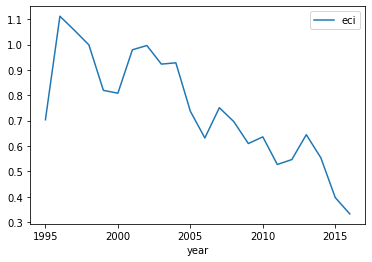

In [ ]:
df = df_ec[df_ec['country_name']=='Ukraine']
# drop duplicates of products
df.drop_duplicates(subset=['country_name','year'],inplace=True)
# keep relevant columns
df = df[['country_name','year','eci']]
# sort by ECI
df.sort_values(by='year',ascending=False,inplace=True)
df.reset_index(inplace=True,drop=True)
df.plot(x='year', y='eci')

##### How does Ukraine&rsquo;s economic complexity in 2015 compare to other countries? Which countries have comparable economic complexity?



In [ ]:
df = df_ec[df_ec['year']==2015].copy()
# drop duplicates of countries
df = df[['country_name','eci']].drop_duplicates()
# sort by ECI
df.sort_values(by='eci',ascending=False,inplace=True)
df.reset_index(inplace=True,drop=True)
# create rank variable
df['rank'] = df.index
# get rank of Ukraine
RANK_UKRAINE = df[df['country_name']=='Ukraine'].reset_index()['rank'][0]
# check countries ranked directly above and below Ukraine
df[ (df['rank']>RANK_UKRAINE-10) & (df['rank']<RANK_UKRAINE+10)]

##### What are the most complex products that Ukraine exported in 2015?



In [ ]:
df = df_ec[df_ec['country_name']=='Ukraine'].copy()
df = df[df['year']==2015]
df.sort_values(by=['pci'],ascending=False,inplace=True)
df.reset_index(inplace=True,drop=True)
df[0:10][['product_name','pci']]

#+begin_example
                                        product_name  pci
0  Horsehair and horsehair waste; whether or not ... 5.49
1  Cooking or heating apparatus of a kind used fo... 5.33
2  Machine-tools; for working any material by rem... 5.31
3  Cermets; articles thereof, including waste and... 5.03
4  Chemical preparations for photographic uses (o... 4.96
5  Photographic (including cinematographic) labor... 4.82
6  Chemical elements doped for use in electronics... 4.73
7                            Artificial filament tow 4.68
8  Tin; tubes, pipes and tube or pipe fittings (e... 4.67
9  Machining centres, unit construction machines ... 4.60
#+end_example